In [42]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [43]:
X = torch.linspace(-10, 10, 100).reshape(-1, 1)
y = (torch.sin(5 * torch.pi * X)) / (5 * torch.pi * X)
def calc_params(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)



In [44]:
#Creating Model
class Model(nn.Module):
    def __init__(self, input_f=1, a1=2, a2=4, output_f=1):
        super().__init__()
        self.fc1 = nn.Linear(input_f,a1)    
        self.fc2 = nn.Linear(a1, a2)
        self.fc3 = nn.Linear(a2, output_f)
    def forward(self, S):
        S = F.relu(self.fc1(S))
        S = F.relu(self.fc2(S))
        S = self.fc3(S)
        return S
model = Model()
print(model)


Model(
  (fc1): Linear(in_features=1, out_features=2, bias=True)
  (fc2): Linear(in_features=2, out_features=4, bias=True)
  (fc3): Linear(in_features=4, out_features=1, bias=True)
)


In [45]:
model_params = calc_params(model)
print(model_params)


21


In [46]:
layer1_params=(1 * 2)
layer2_params=(2 * 4)
layer3_params=( 4 * 1)
total_model_params = (1 * 2) + (2 * 4) + ( 4 * 1)

In [47]:





criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
no_iterations = 8
epochs = 30
epoch_num = epochs // 3  # Use integer division for clarity
mod_losses = []
c = 0

# Preallocate tensors for storing weights and loss
layer2_weights_tensor = torch.zeros((no_iterations * epoch_num, layer2_params))
whole_mod_weights_tensor = torch.zeros((no_iterations * epoch_num, total_model_params))
loss_tensor = torch.zeros((no_iterations * epoch_num, 1))

# Training loop
for iteration in range(no_iterations):
    model = Model()
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    
    for epoch in range(1, epochs + 1):
        # Forward pass
        y_pred = model(X)
        
        # Compute loss
        loss = criterion(y_pred, y)
        mod_losses.append(loss.item())  # Save loss for tracking

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Every 3 epochs, collect weights and loss of the model
        if epoch % 3 == 0:
            # Collect weights from each layer
            lay1_weights = model.fc1.weight.flatten().unsqueeze(0)  # Reshape to (1, layer1_params)
            lay2_weights = model.fc2.weight.flatten().unsqueeze(0)  # Reshape to (1, layer2_params)
            lay3_weights = model.fc3.weight.flatten().unsqueeze(0)  # Reshape to (1, layer3_params)
            
            # Combine all layer weights into a single tensor
            whole_mod_weights = torch.cat([lay1_weights, lay2_weights, lay3_weights], dim=1)
            
            # Save weights and loss to preallocated tensors
            whole_mod_weights_tensor[c] = whole_mod_weights
            layer2_weights_tensor[c] = lay2_weights
            loss_tensor[c] = loss.item()
            c += 1


In [48]:

def pca_implementation(input_array, dimensions_to_retain):
    # Get the number of samples (m) and features (n)
    m, n = input_array.shape
    
    # Step 1: Normalize the input array (subtract the mean from each feature)
    means = np.mean(input_array, axis=0)
    input_normalized = input_array - means
    
    # Step 2: Calculate the covariance matrix
    covariance_matrix = np.dot(input_normalized.T, input_normalized) / (m - 1)
    
    # Step 3: Calculate eigenvalues and eigenvectors of the covariance matrix
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    
    # Step 4: Sort eigenvalues and corresponding eigenvectors in descending order
    sorted_indices = np.argsort(eigenvalues)[::-1]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    
    # Step 5: Select the top 'dimensions_to_retain' eigenvectors
    selected_eigenvectors = sorted_eigenvectors[:, :dimensions_to_retain]
    
    # Step 6: Project the data onto the selected eigenvectors (reduce dimensions)
    reduced_dimension_data = np.dot(input_normalized, selected_eigenvectors)
    
    return reduced_dimension_data


In [49]:
# Detach and move tensors to CPU, then convert to NumPy
layer2_weights_np = layer2_weights_tensor.detach().cpu().numpy()
whole_model_weights_np = whole_mod_weights_tensor.detach().cpu().numpy()
loss_vector_np = loss_tensor.detach().cpu().numpy()

# Perform PCA to reduce dimensions to 2
layer2_weights_reduced = pca_implementation(layer2_weights_np, 2)
whole_model_weights_reduced = pca_implementation(whole_model_weights_np, 2)


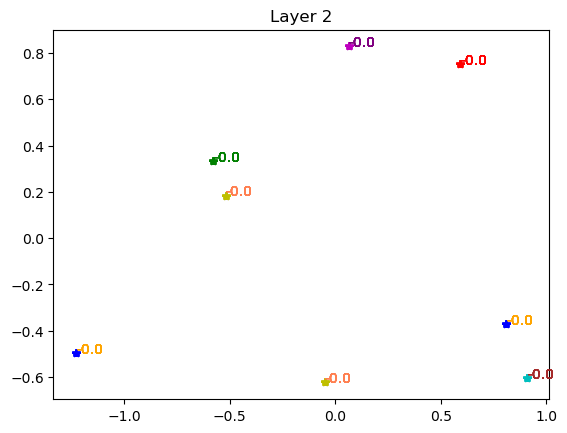

In [51]:
import matplotlib.pyplot as plt

# Define colors and labels
color_markers = ['y*', 'b*', 'g*', 'r*', 'c*', 'm*']
color_names = ["coral", "orange", "green", "red", "brown", "purple"]

# Initialize counters
color_counter = 0

# Plot Layer 2 weights after PCA reduction
for i, pair in enumerate(layer2_weights_reduced):
    # Change color every 10 iterations
    if i % 10 == 0 and i != 0:
        color_counter = (color_counter + 1) % len(color_markers)
    
    # Plot the points with corresponding colors
    plt.plot(pair[0], pair[1], color_markers[color_counter])
    
    # Annotate the points with loss values
    plt.annotate(str(round(loss_vector_np[i][0], 2)), (pair[0], pair[1]), color=color_names[color_counter])

# Set the title and show the plot
plt.title("Layer 2")
plt.show()


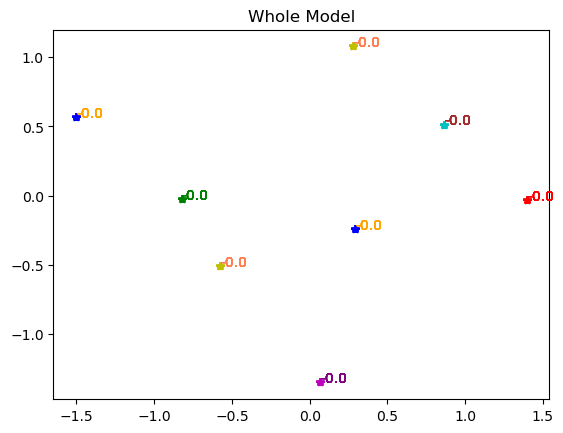

In [52]:
# Initialize counters
color_counter = 0

# Plot the whole model's weights after PCA reduction
for i, pair in enumerate(whole_model_weights_reduced):
    # Change color every 10 iterations
    if i % 10 == 0 and i != 0:
        color_counter = (color_counter + 1) % len(color_markers)
    
    # Plot the points with corresponding colors
    plt.plot(pair[0], pair[1], color_markers[color_counter])
    
    # Annotate the points with loss values
    plt.annotate(str(round(loss_vector_np[i][0], 2)), (pair[0], pair[1]), color=color_names[color_counter])

# Set the title and show the plot
plt.title("Whole Model")
plt.show()
